In [1]:
import time
import pandas as pd
import gc

# helper function to test the different implementations of matrix multiplication
def test_function(function, identifier, A, B):
    gc.disable()
    start_time = time.time()
    C = function(A, B)
    end_time = time.time()
    duration = end_time - start_time
    gc.enable()
    print(f"duration for {identifier}: {duration:.4e}")

    return {"function": identifier, "duration": duration, "results": C}


test_results = []

In [2]:
import numpy as np 

A = np.array([[1, 2, 3], [4, 5, 6]])
B = np.array([[7, 8], [9, 10], [11, 12]])
A,B

(array([[1, 2, 3],
        [4, 5, 6]]),
 array([[ 7,  8],
        [ 9, 10],
        [11, 12]]))

## NUMPY Matrix Multiplication (Naive)

In [3]:
# define naive matrix multiplication in numpy
import numpy as np

def matrix_multiply_np(A, B):
    result = np.zeros((A.shape[0], B.shape[1]))

    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                result[i][j] += A[i][k] * B[k][j]
    return result


In [4]:

%%time
numpy_result = matrix_multiply_np(A, B)
numpy_result

CPU times: user 37 µs, sys: 19 µs, total: 56 µs
Wall time: 59.8 µs


array([[ 58.,  64.],
       [139., 154.]])

## NUMPY Matrix Multiplication (vectorized)

In [5]:

%%time
numpy_result_vec = np.matmul(A, B)
numpy_result_vec

CPU times: user 85 µs, sys: 0 ns, total: 85 µs
Wall time: 89.2 µs


array([[ 58,  64],
       [139, 154]])

## NUMBA Matrix Multiplication

In [6]:
import numba 

@numba.jit(nopython=True)
def matrix_multiply_numba(A, B):
    result = np.zeros((A.shape[0], B.shape[1]))

    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                result[i][j] += A[i][k] * B[k][j]
    return result



## First time NUMBA Function is called

In [7]:
%%time
numba_result = matrix_multiply_numba(A, B)
numba_result

CPU times: user 1.7 s, sys: 859 ms, total: 2.56 s
Wall time: 817 ms


array([[ 58.,  64.],
       [139., 154.]])

## Second time NUMBA Function is called

In [8]:
%%time
numba_result = matrix_multiply_numba(A, B)
numba_result

CPU times: user 22 µs, sys: 10 µs, total: 32 µs
Wall time: 35 µs


array([[ 58.,  64.],
       [139., 154.]])

## CYTHON Matrix Multiplication Version 1

In [9]:
%load_ext Cython

In [10]:
%%cython
import numpy as np

def matrix_multiply_cython(A, B):
    result = np.zeros((A.shape[0], B.shape[1]))

    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                result[i][j] += A[i][k] * B[k][j]
    return result



In [11]:
%time 
cython_result = matrix_multiply_cython(A, B)
cython_result

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs


array([[ 58.,  64.],
       [139., 154.]])

## Large Matrix Multiplication

In [12]:
test_results = []

DIM_SIZE = 200
np.random.seed(0)
# Create two random square matrices
A = np.random.rand(DIM_SIZE, DIM_SIZE)
B = np.random.rand(DIM_SIZE, DIM_SIZE)
A.shape, B.shape


((200, 200), (200, 200))

## NUMPY Naive LARGE MATRIX Multiplication

In [13]:
%%time
test_results.append(test_function(matrix_multiply_np, "numpy_naive", A, B))

duration for numpy_naive: 6.2463e+00
CPU times: user 6.25 s, sys: 0 ns, total: 6.25 s
Wall time: 6.25 s


## NUMPY Vectorized LARGE MATRIX Multiplication

In [14]:
%%time
test_results.append(test_function(np.matmul, "numpy_vectorized", A, B))

duration for numpy_vectorized: 1.0513e-02
CPU times: user 145 ms, sys: 0 ns, total: 145 ms
Wall time: 10.7 ms


## NUMBA LARGE MATRIX Multiplication

In [15]:
%%time
test_results.append(test_function(matrix_multiply_numba, "numba", A, B))

duration for numba: 1.5597e-01
CPU times: user 847 ms, sys: 355 ms, total: 1.2 s
Wall time: 159 ms


## CYTHON LARGE MATRIX Multiplication Version 1

In [16]:
%%time
test_results.append(test_function(matrix_multiply_cython, "cythonv1", A, B))

duration for cythonv1: 5.2553e+00
CPU times: user 5.33 s, sys: 0 ns, total: 5.33 s
Wall time: 5.26 s


## CYTHON MATRIX Multiplication Version 2

In [17]:
%%cython

cimport cython
from libc.stdlib cimport calloc, free

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef matrix_multiply_cython2(double[:, ::1] A, double [:, ::1] B):
    # Declare integer variables for loop counters and matrix dimensions
    cdef int i, j, k
    cdef int nrows_A = len(A)  # Number of rows in matrix A
    cdef int ncols_B = len(B[0])  # Number of columns in matrix B
    cdef int ncols_A = len(A[0])  # Number of columns in matrix A

    # Allocate memory for the result matrix and initialize it with zeros
    cdef double[:,:] result = <double[:nrows_A, :ncols_B]> calloc(nrows_A * ncols_B, sizeof(double))

    # Perform matrix multiplication
    for i in range(nrows_A):  # Iterate over rows of A
        for j in range(ncols_B):  # Iterate over columns of B
            # Compute dot product of i-th row of A and j-th column of B
            for k in range(ncols_A):
                result[i][j] += A[i][k] * B[k][j]

    # Return the result matrix
    return result

In [18]:
%%time
test_results.append(test_function(matrix_multiply_cython2,"cythonv2", A, B))

duration for cythonv2: 1.3641e-02
CPU times: user 14.3 ms, sys: 0 ns, total: 14.3 ms
Wall time: 13.8 ms


In [19]:
df = pd.DataFrame(test_results)
df

,function,duration,results
0,numpy_naive,6.246277,"[[46.7619035508464, 51.01059403987534, 50.7739..."
1,numpy_vectorized,0.010513,"[[46.7619035508464, 51.01059403987535, 50.7739..."
2,numba,0.155974,"[[46.7619035508464, 51.01059403987534, 50.7739..."
3,cythonv1,5.255262,"[[46.7619035508464, 51.01059403987534, 50.7739..."
4,cythonv2,0.013641,"[[46.7619035508464, 51.01059403987534, 50.7739..."


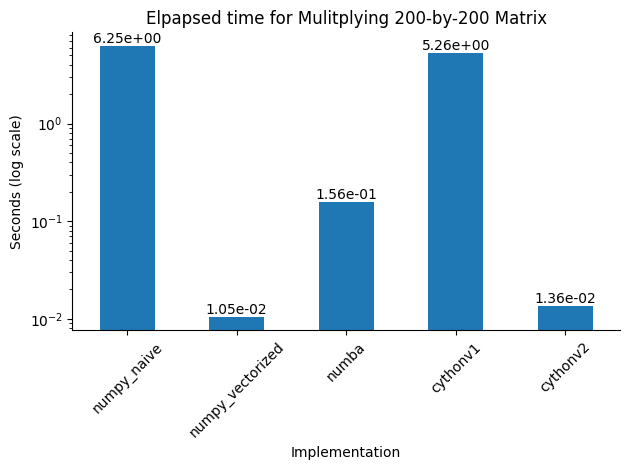

In [20]:
import matplotlib.pyplot as plt

# Define the desired order
order = ['numpy_naive', 'numpy_vectorized', 'numba', 'cythonv1', 'cythonv2']

# Sort the DataFrame by the 'function' column based on the desired order
df['function'] = df['function'].astype('category')
df['function'] = df['function'].cat.set_categories(order)
df.sort_values('function', inplace=True)

# Plot the data
ax = df.plot(kind='bar', x='function', y='duration', legend=False)

plt.xlabel('Implementation')
plt.ylabel('Seconds (log scale)')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title(f'Elpapsed time for Mulitplying {DIM_SIZE}-by-{DIM_SIZE} Matrix')

# Add duration values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2e'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'top', 
                xytext = (0, 10), 
                textcoords = 'offset points')
# Remove top and right lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.show()